In [1]:
%load_ext autoreload
%autoreload 2

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib import rc
import os, sys, time
import scipy.interpolate as interp

import astropy.constants as const
import astropy.units as u
from astropy.cosmology import z_at_value
from astropy.cosmology import WMAP9 as cosmo
from fractions import Fraction

import hasasia.sensitivity as hassens
import hasasia.sim as hassim
import hasasia.skymap as hassky

In [3]:
rc('text',usetex=True)
rc('font',**{'family':'serif','serif':['Times New Roman'],'size':14})#,'weight':'bold'})

In [4]:
current_path = os.getcwd()
splt_path = current_path.split("/")
top_path_idx = splt_path.index('DetectorDesignSensitivities')
top_directory = "/".join(splt_path[0:top_path_idx+1])
load_directory = top_directory + '/LoadFiles/InstrumentFiles/'

sys.path.insert(0,top_directory + '/Functions')
import HorizonDistance as HD
import binary,detector,snr

import gwent
from gwent import utils

load_directory = gwent.__path__[0] + '/LoadFiles/InstrumentFiles/'

In [5]:
fig_save_idx = splt_path.index('Research')
fig_save_location = "/".join(splt_path[0:fig_save_idx+1])
fig_save_location += '/paperfigs'

In [6]:
axissize = 14
labelsize = 16
legendsize = 12
figsize = (10,8)
colornorm = colors.Normalize(vmin=0.0, vmax=5.0)
linesize = 3

In [7]:
'''
NOT REALLY YET.
    Variables: 
        GLOBAL:
            'T_obs' - Observation Time
        SOURCE:
            'M' - Mass (Solar Units)
            'q' - Mass Ratio
            'chi1' - Spin1
            'chi2' - Spin2
            'z' - Redshift
        LISA ONLY:
            'L' - Armlength
            'A_acc' - Acceleration Noise
            'A_IMS' - Optical Metrology
            'f_acc_break_low'
            'f_acc_break_high'
            'f_IMS_break'
        PTAs ONLY:
            'N_p' - Number of Pulsars
            'sigma' - Timing Error RMS
            'cadence' - cadence
'''
var_x = 'M' #Variable on x-axis

sampleRate_x = 10 #Number of x-axis points

In [8]:
#Selects which noise curve:
#							0 is Einstein Telescope, 
#							1 is aLIGO, 
#							2 is NANOGrav 15yr,
#							3 is SKA (2030s),
#							4 is Neil Cornish's,
#							anything else is the L3 proposal

# Source Selection

In [9]:
def Get_Source(model):
    if model == 0 or model == 1:
        #M = m1+m2 Total Mass
        M = 1e2
        M_min = 1e0
        M_max = 1e5
    elif model == 2 or model == 3:
        #M = m1+m2 Total Mass
        M = 1e8
        M_min = 1e7
        M_max = 1e11
    else:
        #M = m1+m2 Total Mass
        M = 1e6
        M_min = 1e1
        M_max = 1e10

    #q = m2/m1 reduced mass
    q = 1.0
    q_min = 1.0
    q_max = 18.0

    #Chi = S_i*L/m_i**2, spins of each mass i
    chi1 = 0.0 #spin of m1
    chi2 = 0.0 #spin of m2
    chi_min = -0.85 #Limits of PhenomD for unaligned spins
    chi_max = 0.85

    z = 3.0 #Redshift
    z_min = 1e-2
    z_max = 1e3

    source = binary.BBHFrequencyDomain(M,q,z,chi1,chi2)
    source.M = [M,M_min,M_max]
    source.q = [q,q_min,q_max]
    source.chi1 = [chi1,chi_min,chi_max]
    source.chi2 = [chi2,chi_min,chi_max]
    source.z = [z,z_min,z_max]

    return source

# Model Selection

In [10]:
def Get_Instrument(model):
    if model == 0: #Einstein Telescope
        #Loaded from http://www.et-gw.eu/index.php/etsensitivities
        load_name = 'ET_D_data.txt'
        load_location = load_directory + 'EinsteinTelescope/StrainFiles/' + load_name

        T_obs = 4*u.yr #Observing time in years
        T_obs_min = 1*u.yr
        T_obs_max = 10*u.yr

        instrument = detector.GroundBased('ET',T_obs,load_location=load_location,I_type='A')
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]

    elif model == 1: #aLIGO
        #Loaded from https://dcc.ligo.org/T1800044/public
        load_name = 'aLIGODesign.txt'
        load_location = load_directory + 'aLIGO/StrainFiles/' + load_name

        T_obs = 4*u.yr #Observing time in years
        T_obs_min = 1*u.yr
        T_obs_max = 10*u.yr

        instrument = detector.GroundBased('aLIGO',T_obs,load_location=load_location,I_type='A')
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]

    elif model == 2: #NANOGrav 15 yr
        #NANOGrav calculation using 11.5yr parameters https://arxiv.org/abs/1801.01837
        T_obs = 15*u.yr #Observing time in years
        T_obs_min = 10*u.yr
        T_obs_max = 30*u.yr

        sigma = 100*u.ns.to('s')*u.s #rms timing residuals in seconds

        N_p = 18 #Number of pulsars

        cadence = 1/(2*u.wk.to('yr')*u.yr) #Avg observation cadence of 1 every 2 weeks in num/year

        instrument = detector.PTA('NANOGrav',T_obs,N_p,sigma,cadence)
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]


    elif model == 3: #SKA (2030s)
        #SKA calculation using parameters and methods from https://arxiv.org/abs/0804.4476 section 7.1
        T_obs = 15*u.yr #Observing time (years)
        T_obs_min = 10*u.yr
        T_obs_max = 30*u.yr

        sigma = 10*u.ns.to('s')*u.s #rms timing residuals in nanoseconds

        N_p = 20 #Number of pulsars

        cadence = 1/(u.wk.to('yr')*u.yr) #Avg observation cadence of 1 every week in num/year

        instrument = detector.PTA('SKA',T_obs,N_p,sigma,cadence)
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]

    elif model == 4: #Robson,Cornish,and Liu 2019, LISA (https://arxiv.org/abs/1803.01944)
        T_obs = 4*u.yr #Observing time in years
        T_obs_min = 1*u.yr
        T_obs_max = 10*u.yr

        L = 2.5e9*u.m #armlength in meters
        L_min = 1.0e7*u.m
        L_max = 1.0e11*u.m

        A_acc = 3e-15*u.m/u.s/u.s #M/s**2
        A_IMS = 1.5e-11*u.m
        f_IMS_break = 2.*u.mHz.to('Hz')*u.Hz
        f_acc_break_low = .4*u.mHz.to('Hz')*u.Hz
        f_acc_break_high = 8.*u.mHz.to('Hz')*u.Hz
        Background = False
        T_type = 'A'

        instrument = detector.SpaceBased('Alt_LISA',\
                                       T_obs,L,A_acc,f_acc_break_low,f_acc_break_high,A_IMS,f_IMS_break,\
                                       Background=Background,T_type=T_type)
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]
        instrument.L = [L,L_min,L_max]

    else: #L3 proposal
        #Default Params from https://arxiv.org/abs/1702.00786
        T_obs = 4*u.yr #Observing time in years
        T_obs_min = 1*u.yr
        T_obs_max = 10*u.yr

        L = 2.5e9*u.m #armlength in meters
        L_min = 1.0e7*u.m
        L_max = 1.0e11*u.m

        f_acc_break_low = .4*u.mHz.to('Hz')*u.Hz
        f_acc_break_high = 8.*u.mHz.to('Hz')*u.Hz
        f_IMS_break = 2.*u.mHz.to('Hz')*u.Hz
        A_acc = 3e-15*u.m/u.s/u.s
        A_IMS = 10e-12*u.m
        Background = False
        T_type = 'N'

        instrument = detector.SpaceBased('LISA_ESA',\
                                       T_obs,L,A_acc,f_acc_break_low,f_acc_break_high,A_IMS,f_IMS_break,\
                                       Background=Background,T_type=T_type)
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]
        instrument.L = [L,L_min,L_max]

    return instrument

# Horizon Distance Calculation

In [90]:
rho_thresh = 5
model = 0
instrument = Get_Instrument(model)
source = Get_Source(model)

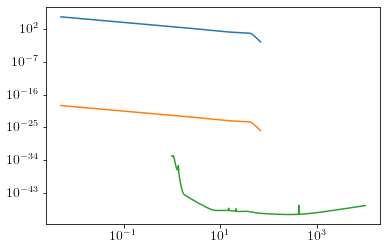

In [91]:
plt.figure()
plt.loglog(source.f,source._phenomD_h)
plt.loglog(source.f,source.h_f)
plt.loglog(instrument.fT,instrument.S_n_f)

In [98]:
start = time.time()
[sample_x,DL_array,z_array] = HD.getHorizonDistance(source,instrument,var_x,sampleRate_x,rho_thresh,redshift_array=z_0)
end = time.time()
print(end-start)

False
False
False
False
False
False
False
False
False
False
Smol DL
Smol DL
Smol DL
Smol DL
0.15241098403930664


dist max:  [  4.   5.   5.   5.   6.   4. -28. -27. -26. -24.]


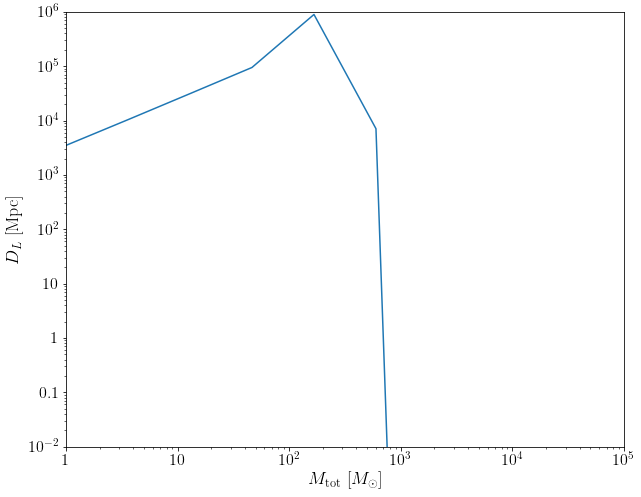

In [97]:
HD.plotHD(source,instrument,var_x,sample_x,DL_array,display=True,figloc=None)

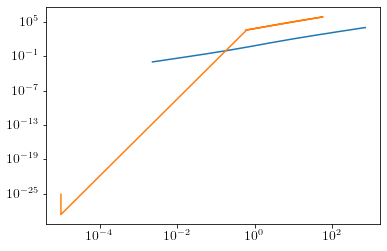

In [90]:
dists = np.linspace(-2,4,len(DL_array))
dists = (10**dists)*u.Gpc
z = [z_at_value(cosmo.luminosity_distance,dist) for dist in dists]
plt.figure()
plt.loglog(z,dists)
plt.loglog(z_array,DL_array)
plt.show()

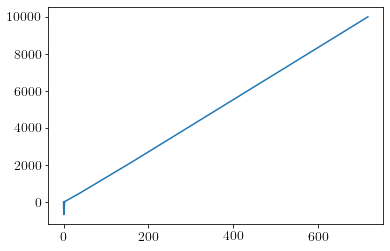

In [51]:
plt.plot(z,dists-DL_array)

In [15]:
z_0 = 1e-2*np.ones(sampleRate_x)
z_1 = 1e3*np.ones(sampleRate_x)

0
Smol DL
Smol DL
Smol DL
z_n:  [1.81035986e-01 6.01279492e+02 9.30728310e+02 1.30359662e-01
 1.97515738e+00 1.49269215e-01 5.75291339e+02 9.29242388e-01
 1.77401359e+01 7.87775322e-01]
584.3114560286103
dist max:  [  1.   6.   7.   6.   7.   7. -22.   6. -21. -21.]


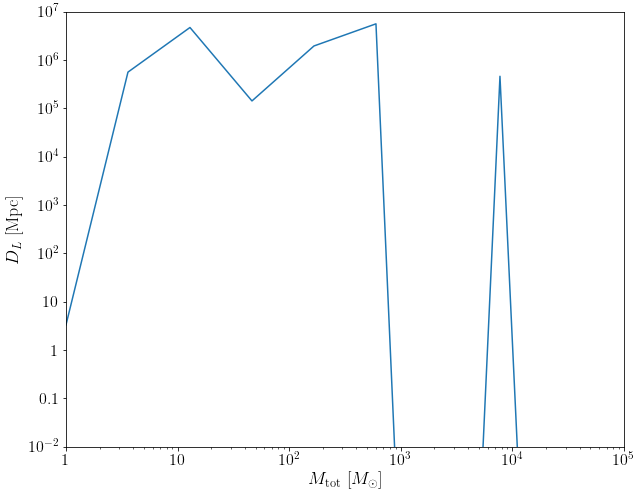

1
Smol DL
Smol DL
z_n_plus_1:  [-4.12852986e-01 -3.06783589e+01 -1.63257272e+02 -1.78400498e+00
 -4.53790905e+01  4.22061164e+02  5.75291339e+02  3.78016751e+01
  1.77401359e+01 -7.72532195e-01]
575.2913286593762
dist max:  [  1.   5.   7.   7.   7.   6.   8. -22.   5. -22.]


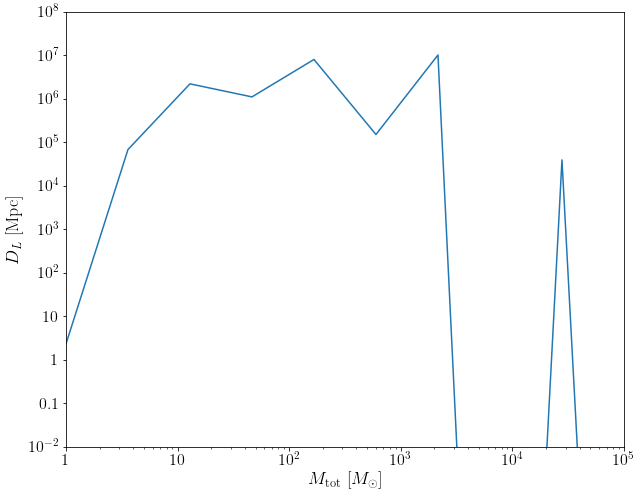

2
Smol DL
Smol DL
Smol DL
z_n_plus_1:  [-5.52483504e-01             nan             nan             nan
             nan  6.96237397e+02  5.75291339e+02             nan
  1.77401359e+01  1.00000000e-05]
274.1762334996372
dist max:  [ -0.  nan  nan  nan  nan   6. -22. -22. -21.   3.]


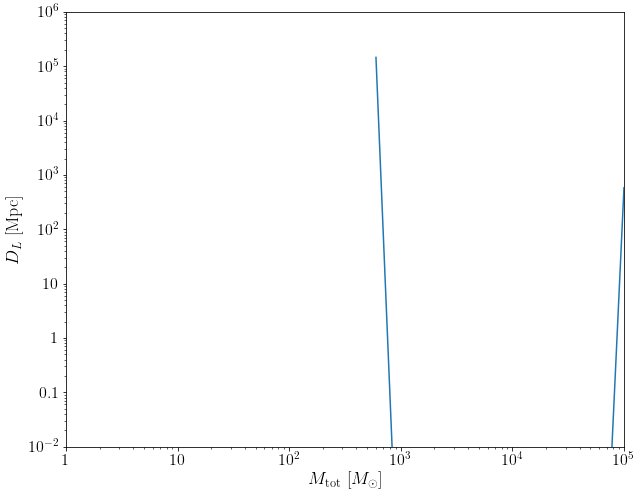

3
Smol DL
Smol DL
Smol DL
z_n_plus_1:  [-6.92860330e-01             nan             nan             nan
             nan  9.42170381e+02             nan             nan
             nan  1.00000000e-05]
245.93298422261523
dist max:  [ -0.  nan  nan  nan  nan   5. -22.  nan -21. -22.]


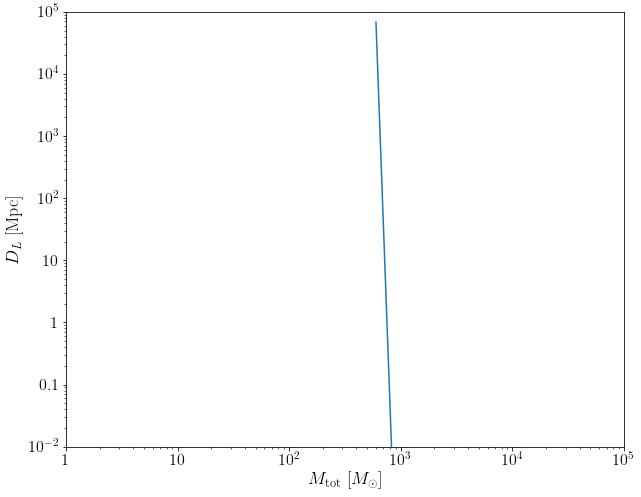

4
Smol DL
z_n_plus_1:  [-7.69364164e-01             nan             nan             nan
             nan  1.36025379e+03             nan             nan
             nan             nan]
418.0834072936069
dist max:  [ -0.  nan  nan  nan  nan   5.  nan  nan  nan -22.]


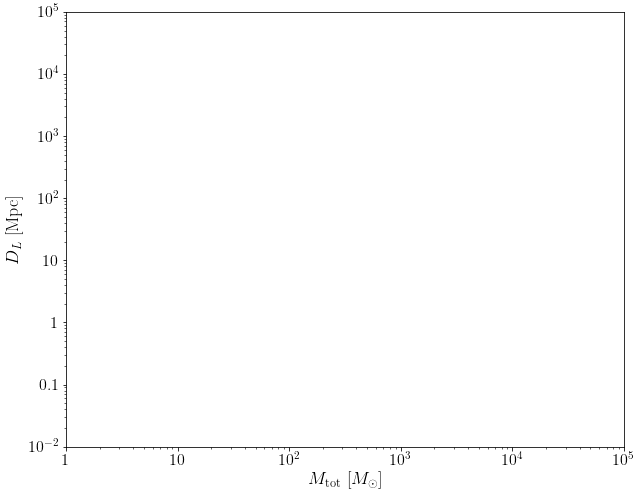

5
z_n_plus_1:  [-8.07243469e-01             nan             nan             nan
             nan  1.80362099e+03             nan             nan
             nan             nan]
443.36720326250247
dist max:  [-1. nan nan nan nan  5. nan nan nan nan]


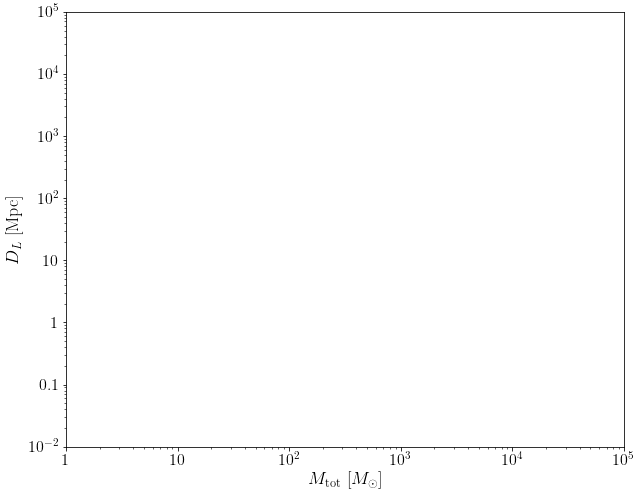

6
Smol DL
z_n_plus_1:  [-8.07243469e-01             nan             nan             nan
             nan  1.97794598e+03             nan             nan
             nan             nan]
174.3249860985352
dist max:  [-34.  nan  nan  nan  nan   4.  nan  nan  nan  nan]


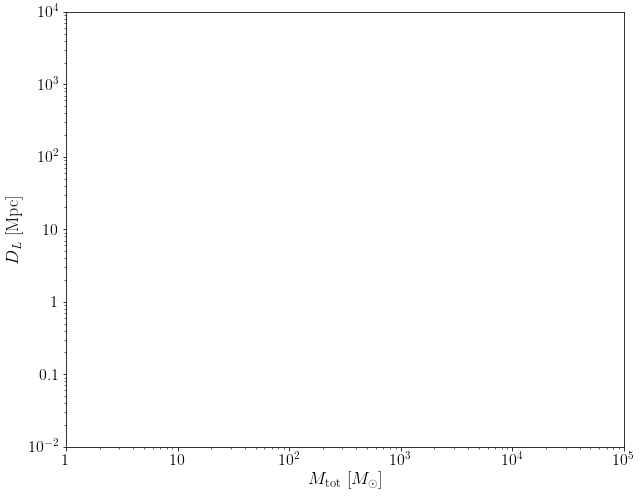

7
Smol DL
z_n_plus_1:  [          nan           nan           nan           nan           nan
 2101.43195657           nan           nan           nan           nan]
nan
dist max:  [-34.  nan  nan  nan  nan   4.  nan  nan  nan  nan]


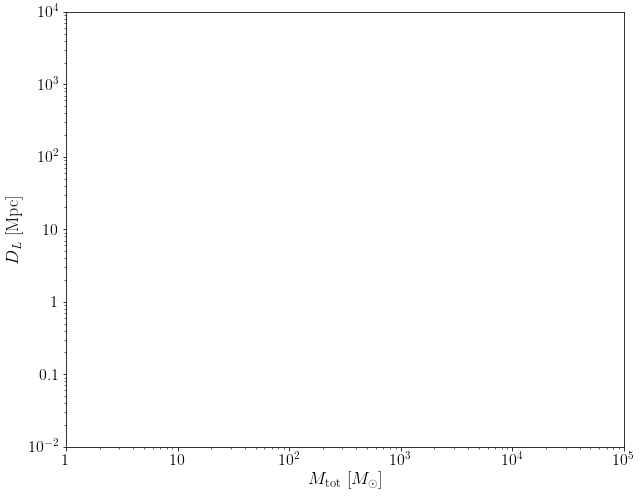

8
z_n_plus_1:  [          nan           nan           nan           nan           nan
 2253.44458688           nan           nan           nan           nan]
nan
dist max:  [nan nan nan nan nan  4. nan nan nan nan]


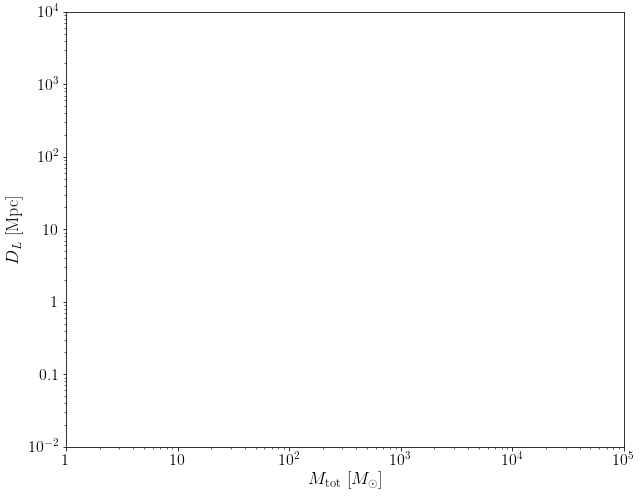

9
z_n_plus_1:  [         nan          nan          nan          nan          nan
 2376.7372891          nan          nan          nan          nan]
nan
dist max:  [nan nan nan nan nan  3. nan nan nan nan]


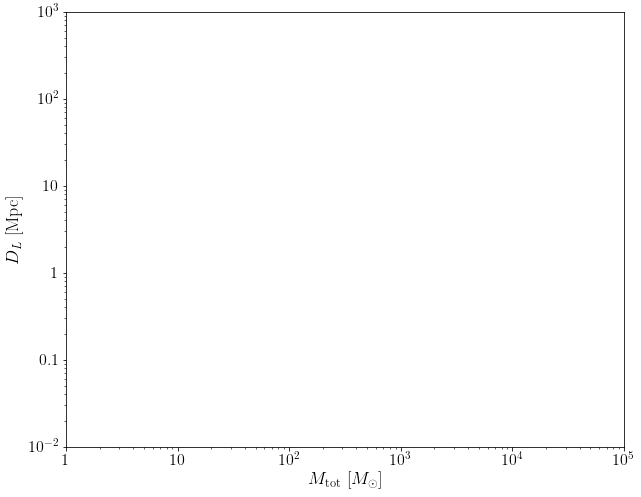

In [86]:
rho_thresh = 5
model = 5
instrument = Get_Instrument(model)
source = Get_Source(model)
i = 0
iter_max = 10
tol = 1e-10

while i < iter_max:
    if i == 0:
        #initial guess
        z_0 = 10**np.random.uniform(-2,3,size=sampleRate_x)
        
        [_,DL_n,z_n] = HD.getHorizonDistance(source,instrument,var_x,sampleRate_x,rho_thresh,z_0)
        print('z_n: ',z_0)
        #Next z
        z_n_plus_1 = z_n
        z_n = z_0
    else:
        #Moving previous values back one slot
        z_n_minus_1 = z_n
        z_n = z_n_plus_1
        DL_n_minus_1 = DL_n
        #Uses z_n_plus_1 from previous to get new z_n
        [_,DL_n,_] = HD.getHorizonDistance(source,instrument,var_x,sampleRate_x,rho_thresh,z_n)
        #Next z
        z_n_plus_1 = z_n - DL_n*(z_n-z_n_minus_1)/(DL_n-DL_n_minus_1)
        print('z_n_plus_1: ',z_n_plus_1)

    print(max(np.abs(z_n_plus_1-z_n)))
    HD.plotHD(source,instrument,var_x,sample_x,DL_n,display=True,figloc=None)
    #plt.loglog(z_n_minus_1,DL_n_minus_1)
    i+=1


In [ ]:
HD.plotHD(source,instrument,var_x,sample_x,DL_n_minus_1,display=True,figloc=None)

In [11]:
def Get_rho_z(z,source,instrument):
    setattr(source,'z',z)
    source.Check_Freq_Evol()
    if source.ismono: #Monochromatic Source
        if hasattr(source,'h_gw'):
            del source.h_gw
        rho_z = snr.Calc_Mono_SNR(source,instrument)
    else: #Chirping Source
        if hasattr(source,'f'):
            del source.f
        if hasattr(source,'h_f'):
            del source.h_f
        rho_z = snr.Calc_Chirp_SNR(source,instrument)
    return rho_z

In [19]:
rho_thresh = 5
model = 5
instrument = Get_Instrument(model)
source = Get_Source(model)
source.instrument = instrument
i = 0
iter_max = 20
tol = 1e-10
#initial guess
z_min = 10**-2
z_max = 10**3

while i < iter_max:
    if i == 0:
        z = np.random.uniform(z_min,z_max)

    rho_z = Get_rho_z(source,instrument,z)
    if np.abs(rho_z-rho_thresh) <= tol:
        print('Converged.')
        i = iter_max
    else:
        if rho_z < rho_thresh:
            z_max = z
        else:
            z_min = z
    print('rho_z: ',rho_z)            
    z = np.random.uniform(z_min,z_max)
    print('z: ',z)
    print('z_max: ',z_max)
    print('z_min: ',z_min)
    print(' ')
        
    i+=1

rho_z:  5.528339727358761
z:  820.9887447488566
z_max:  1000
z_min:  91.33095276991496
 
rho_z:  0.023348399754268882
z:  552.818545489235
z_max:  820.9887447488566
z_min:  91.33095276991496
 
rho_z:  0.06342122757562353
z:  547.1970457361712
z_max:  552.818545489235
z_min:  91.33095276991496
 
rho_z:  0.06507399808702749
z:  314.6823269905529
z_max:  547.1970457361712
z_min:  91.33095276991496
 
rho_z:  0.2613070775747371
z:  106.59824804675792
z_max:  314.6823269905529
z_min:  91.33095276991496
 
rho_z:  3.8154039317201636
z:  93.61638394504402
z_max:  106.59824804675792
z_min:  91.33095276991496
 
rho_z:  5.211922888485772
z:  98.78648389937538
z_max:  106.59824804675792
z_min:  93.61638394504402
 
rho_z:  4.582643708176118
z:  94.46880054066528
z_max:  98.78648389937538
z_min:  93.61638394504402
 
rho_z:  5.100292345209884
z:  96.39481093814652
z_max:  98.78648389937538
z_min:  94.46880054066528
 
rho_z:  4.859917427525552
z:  94.79971369584916
z_max:  96.39481093814652
z_min:  94.

In [50]:
z_range = np.linspace(-2,3,100)
rho = []
for z in z_range:
    rho.append(Get_rho_z(source,instrument,10**z))

In [60]:
rho_interp = interp.interp1d(rho,z_range,kind='cubic',fill_value=0., bounds_error=False)
z_val = rho_interp(rho_thresh)
print(rho_thresh)
print(z_val)

5
1.9788912779870458


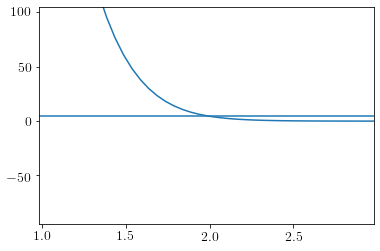

In [61]:
rho_thresh = 5
plt.figure()
plt.plot(z_range,rho)
plt.axhline(y=rho_thresh)
plt.ylim([rho_thresh-100,rho_thresh+100])
plt.xlim([z_val-1,z_val+1])
plt.show()